In [1]:
import torch
import numpy as np
import torch.nn as nn
from tqdm import trange
import torch.nn.functional as F
import matplotlib.pyplot as plt

from edunets import functions, losses
from edunets.tensor import Tensor

(<matplotlib.image.AxesImage at 0x7f6f33812a30>, 5)

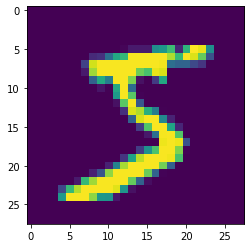

In [2]:
# load the mnist dataset

def fetch(url):
    import requests, gzip, os, hashlib, numpy
    fp = os.path.join("/tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
    if os.path.isfile(fp):
        with open(fp, "rb") as f:
            dat = f.read()
    else:
        with open(fp, "wb") as f:
            dat = requests.get(url).content
            f.write(dat)
    return numpy.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()

X_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

plt.imshow(X_train[0]), Y_train[0]

# In Pytorch

In [9]:
# Pytorch model and training tensors

class TorchNet(nn.Module):
    def __init__(self):
        super(TorchNet, self).__init__()
        self.l1 = nn.Linear(28*28, 128, bias=False)
        self.l2 = nn.Linear(128, 10, bias=False)
        self.sm = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.l1(x) # first layer
        x = F.relu(x)  # activation function
        x = self.l2(x) # secound layer: down to 10 outputs
        #x = self.sm(x) # softmax
        return x

dummy_tensor = torch.Tensor([X_train[0].reshape(28*28)])
print("Does dummy_tensor require a gradient ?", dummy_tensor.requires_grad)
dummy_output = TorchNet()(dummy_tensor)
print("Does dummy_output require a gradient ?", dummy_output.requires_grad)


Does dummy_tensor require a gradient ? False
Does dummy_output require a gradient ? True


In [10]:
# Testing two different losses

nn_NLLLoss = nn.NLLLoss(reduction="mean")
nn_MSELoss = nn.MSELoss(reduction="mean")
nn_CrossEntropyLoss = nn.CrossEntropyLoss(reduction="mean")

def NLLLoss(Y_pred, Y):
    """
    works well (with a final LogSoftmax layer !)
    """
    loss = nn_NLLLoss(Y_pred, Y)
    accuracy = (torch.argmax(Y_pred, dim=1) == Y).float().mean().item()

    return loss, accuracy

def MSELoss(Y_pred, Y):
    """
    doesn't work at all
    """
    Y_one_hot = torch.zeros(Y.shape[0], 10)
    slice = [(i, y) for i, y in enumerate(Y)] if Y.shape[0] > 1 else (0,Y[0])
    Y_one_hot[slice] = 1.0

    loss = nn_MSELoss(Y_pred, Y_one_hot)

    accuracy = (torch.argmax(Y_pred, dim=1) == Y).float().mean().item()
    
    return loss, accuracy

def CrossEntropyLoss(Y_pred, Y):
    """
    works well 
    """
    loss = nn_CrossEntropyLoss(Y_pred, Y)
    accuracy = (torch.argmax(Y_pred, dim=1) == Y).float().mean().item()

    return loss, accuracy

loss 0.93 accuracy 0.77:   3%|▎         | 26/1000 [00:00<00:03, 256.89it/s]

Y_pred: tensor([ 14.,   4.,  21., -11., -12.,  17.,  22., -12.,   6.,   4.],
       grad_fn=<RoundBackward>)
Y: tensor(9)
Y_pred after argmax: tensor(6)
loss: tensor(31.8167, grad_fn=<NllLossBackward>)


loss 0.12 accuracy 0.95: 100%|██████████| 1000/1000 [00:03<00:00, 304.84it/s]


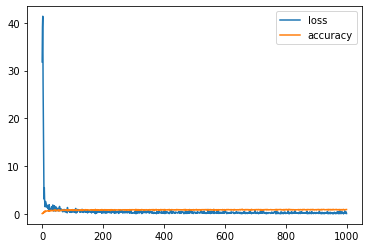

In [12]:
# Pytorch Training

model = TorchNet()

# Loss function defined above
loss_fn = CrossEntropyLoss

# Stocastic gradient descent
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0)

# Training paramaters
epochs = 1000
batch_size = 64

losses, accuracies = [], []

# Training loop
for i in (t := trange(epochs)):
    # Get random slicing the size of the batch
    sample = np.random.randint(0, X_train.shape[0], size=(batch_size))

    # Define X and Y (flatten X so the image is one single dimention)
    # Conversion to float is important so the Linear layers accept X as a input
    X = torch.tensor(X_train[sample].reshape(-1, 28*28), dtype=torch.float)
    Y = torch.tensor(Y_train[sample], dtype=torch.long)

    Y_pred = model(X)

    # This prints shows the form of Y_pred, it is clear argmax needs to be applied
    # to compare Y_pred with Y
    if i == 0:
        print("Y_pred:", Y_pred[0].round())
        print("Y:", Y[0])
        print("Y_pred after argmax:", torch.argmax(Y_pred, dim=1)[0])
    
    loss, accuracy = loss_fn(Y_pred, Y)

    if i == 0:
        print("loss:", loss)

    # Backpropagation
    loss.backward()

    # Updating weights
    optimizer.step()

    # Reset weights for next epoch
    model.zero_grad()

    loss = loss.item()
    losses.append(loss)
    accuracies.append(accuracy)
    t.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))

plt.plot(losses, label="loss")
plt.plot(accuracies, label="accuracy")
plt.legend()
plt.show()


# In Edunets

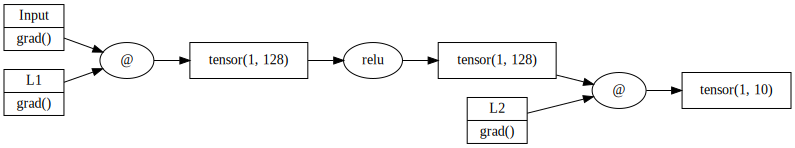

In [3]:
class EduNet1:
    def __init__(self):
        self.l1 = Tensor.uniform(784, 128, requires_grad=True, label="L1")
        self.l2 = Tensor.uniform(128, 10, requires_grad=True, label="L2")

    def __call__(self, x):
        x = x @ self.l1
        x = x.relu()
        x = x @ self.l2
        return x

model = EduNet1()
dummy_tensor = Tensor([X_train[0].reshape(28*28)], requires_grad=True, label="Input")
dummy_output = model(dummy_tensor)
dummy_output.graph

In [4]:
# Stochastic gradient descent
class SGD:
    def __init__(self, params, lr=0.001):
        self.lr = lr
        self.params = params

    def step(self):
        for t in self.params:
            t.assign(t.data - t.grad * self.lr)

    def zero_grad(self):
        for param in self.params:
            param.grad = None

tensor([[-0.2566039 , -0.2258296 , -0.08617255, ..., -0.89583886,
        -0.58731484,  0.4696555 ],
       [-0.62403965, -0.07558823, -0.796615  , ...,  0.3121705 ,
         0.9693934 , -0.07574746],
       [-0.7055167 , -0.8265209 ,  0.12973449, ..., -0.905165  ,
        -0.651612  ,  0.2554413 ],
       ...,
       [ 0.72892815,  0.35551333, -0.33884954, ..., -0.6703916 ,
         0.44329488, -0.77913845],
       [ 0.28709593, -0.3184582 , -0.99319535, ...,  0.40193695,
        -0.12924731,  0.60744554],
       [-0.13272536, -0.24644704, -0.50464416, ..., -0.7125822 ,
         0.87835956,  0.80373394]], dtype=float32, requires_grad=True)


  0%|          | 0/100 [00:00<?, ?it/s]/home/goncalo/edunets/edunets/tensor.py:281: RuntimeWarning: overflow encountered in exp
  f = Tensor(np.exp(a.data))._parent_of((a, ))._result_of_op('e')
/home/goncalo/edunets/edunets/tensor.py:318: RuntimeWarning: invalid value encountered in matmul
  a._update_grad(f.grad @ b.data.T)
/home/goncalo/edunets/edunets/tensor.py:319: RuntimeWarning: invalid value encountered in matmul
  b._update_grad(a.data.T @ f.grad)
loss nan accuracy 0.11: 100%|██████████| 100/100 [00:01<00:00, 80.88it/s]


tensor([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32, requires_grad=True)


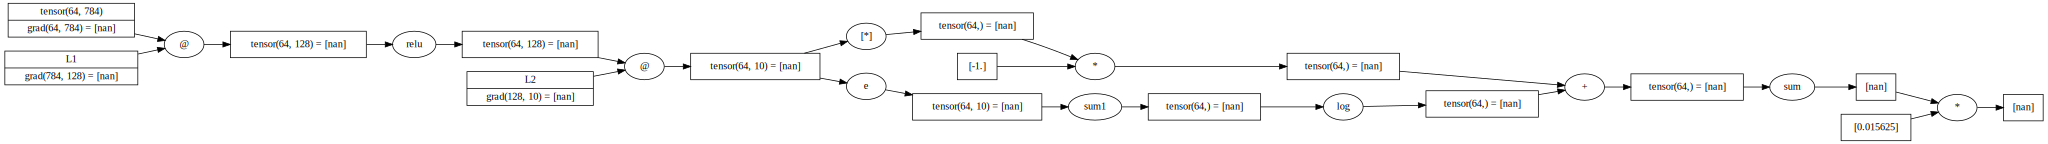

In [5]:
from edunets.losses import CrossEntropyLoss

model = EduNet1()

loss_fn = CrossEntropyLoss(reduction="mean")
optim = SGD([model.l1, model.l2], lr=0.001)
batch_size = 64
epochs = 100
losses, accuracies = [], []

print(model.l1)

for i in (t := trange(epochs)):
    samp = np.random.randint(0, X_train.shape[0], size=(batch_size))

    X = Tensor(X_train[samp].reshape((-1, 28*28)), requires_grad=True)
    Y = Tensor(Y_train[samp])

    out = model(X)
    
    cat = functions.argmax(out, axis=1)
    
    accuracy = (cat == Y).mean()

    loss = loss_fn.forward(out, Y)
    
    optim.zero_grad()
    
    loss.backward()
    
    optim.step()
    
    losses.append(loss.data)
    
    accuracies.append(accuracy.data)
    
    t.set_description("loss %.2f accuracy %.2f" % (loss.data, accuracy.data))

print(model.l1)
loss.graph
